In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [19]:
card_df = pd.read_csv('/content/drive/MyDrive/파이썬 머신러닝 완벽 가이드/04 분류/creditcard.csv')

card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [20]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  df_copy.drop('Time', axis=1, inplace=True)
  return df_copy

In [21]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
  # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
  df_copy = get_preprocessed_df(df)
  # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
  X_features = df_copy.iloc[:, :-1]
  y_target = df_copy.iloc[:, -1]
  # train_test_split()으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
  X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
  # 학습과 테스트 데이터 세트 반환
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [22]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64



학습 데이터 레이블의 경우 1값이 약 0.172%, 테스트 데이터 레이블의 경우 1 값이 약 0.173%로 큰 차이 없이 잘 분할 되었음



In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix( y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  # ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  # ROC-AUC 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [25]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# get_clf_eval() 함수를 이용해 평가 수행.
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85280    15]
 [   55    93]]
정확도: 0.9992, 정밀도: 0.8611, 재현율: 0.6284, F1: 0.7266, AUC:0.9568


테스트 데이터 세트로 측정 시 재현율 0.6284, ROC-AUC:0.9568

---
<br>

이번엔 `LightGBM`을 이용한 모델을 생성

그에 앞서, 앞으로 수행할 예제 코드에서 반복적으로 모델을 변경해 학습/예측/평가할 것이므로 이를 위한 벼로의 함수를 생성한다.


`get_model_train_eval()`는 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가를 수행하는 역할을 하는 함수이다.


In [26]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
  model.fit(ftr_train, tgt_train)
  pred = model.predict(ftr_test)
  pred_proba = model.predict_proba(ftr_test)[:, 1]
  get_clf_eval(tgt_test, pred, pred_proba)


먼저, 본 데이터 세트는 극도로 불균형한 레이블 값 분포도를 가지고 있으므로 LGBMClassifier 객체 생성 시 boost_from_average=False로 파라미터를 설정해야 한다.

In [27]:
from lightgbm import LGBMClassifier

In [28]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)

get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568, F1: 0.8421, AUC:0.9797



재현율 0.7568, ROC-AUC 0.9797로 앞의 로지스틱 회귀보다 높은 수치를 나타냄.



<br>

---

### 데이터 분포도 변환 후 모델 학습/예측/평가

이번에는 왜곡된 분포도를 가지는 데이터를 재가공한 뒤에 모델을 다시 테스트흔다.

먼저 creditcard.csv의 중요 피처 값의 분포도를 살펴본다.

로지스틱 회귀는 선형 모델이다. 대부분의 선형 모델은 중요 피처들의 값이 정규 분포 형태를 유지하는 것을 선호한다.

Amount 피처는 신용 카드 금액으로 정상/사기 트랜잭션을 결정하는 매우 중요한 속성일 가능성이 높은데, 이 Amount 피처의 분포도를 확인한다.



In [29]:
import seaborn as sns

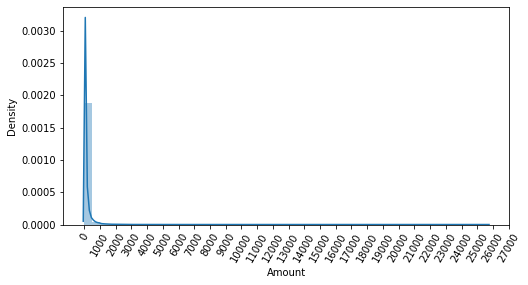

In [33]:
plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

Amount, 즉 카드 사용금액이 1000불 이하인 데이터가 대부분이며, 27,000불까지 드물지만 많은 금액을 사용한 경우가 발생하면서 꼬리가 긴 형태의 분포 곡선을 가지고 있다.

Amount를 표준 정규 분포 형태로 변환한 뒤에 로지스틱 회구의 예측 성능을 측정한다.

이를 위해 앞에서 만든 get_processed_df() 함수를 다음과 같이 사이킷런의 StandardScaler 클래스를 이용해 Amount 피처를 정규 분포 형태로 변환하는 코드로 변경한다.



In [34]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정.

def get_preprocessed_df(df=None):
  df_copy = df.copy()
  scaler = StandardScaler()
  amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
  # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 칼럼으로 입력
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  # 기존 Time, Amount 피처 삭제
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  return df_copy


함수를 수정한 후 get_train_test_dataset()를 호출해 학습/테스트 데이터 세트를 생성한 후에 get_model_train_eval()를 이용해 로지스틱 회귀와 LightGBM 모델을 각각 학습/예측/평가 한다.



In [47]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행.
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85291     4]
 [   25   121]]
정확도: 0.9997, 정밀도: 0.9680, 재현율: 0.8288, F1: 0.8930, AUC:0.9831



정규 분포 형태로 Amount 피처값을 변환한 후 테스트 데이터 세트에 적용한 로지스틱 회귀 및 LightGBM 두 모델 모두 변환 이전과 비교해 성능이 크게 개선되지는 않았다.




---

<br>

이번에는 StandardScaler가 아니라 로그 변환을 수행한다.

로그 변환은 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법 중에 하나이다.

원래 값을 log 값으로 변환해 원래 큰 값을 상대적으로 작은 값으로 변환하기 때문에 데이터 분포도의 왜곡을 상당 수준 개선해준다. - 이는 5장에서 더 자세하게 다룬다.

데이터 가공 함수인 get_preprocessed_df()를 로그 변환 로직으로 변경한다.



In [36]:
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  # 넘파이의 log1p()를 이용해 Amount를 로그 변환
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  return df_copy
  

In [48]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85291     4]
 [   25   121]]
정확도: 0.9997, 정밀도: 0.9680, 재현율: 0.8288, F1: 0.8930, AUC:0.9831



두 모델 모두 정밀도, 재현율, ROC-AUC에서 약간씩 성능이 개선되었음을 나타내고 있다.

<br>

---

<br>

### 이상치 데이터 제거 후 모델 학습/예측/평가

이상치 데이터(Outlier)는 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터이며, 아웃라이어라고도 불린다.

이상치로 인해 머신러닝 모델의 성능에 영향을 받는 경우가 발생하기 쉽다.

이러한 이상치를 찾아내는 방법을 알아보고, 이들 데이터를 제거한 뒤에 다시 모델을 평가한다.

이상치를 찾는 방법은 여러 가지가 있다. 이 중, `IQR(Inter Quantile Range)` 방식을 적용한다.

`IQR`은 사분위(Qunatile) 값의 편차를 이용하는 기법으로 흔히 박스 플롯 (Box Plot) 방식으로 시각화 할 수 있다.

<br>

---

먼저 사분위에 대해 알아본다. 사분위는 전체 데이터를 값이 높은 순으로 정렬하고, 이를 1/4(25%) 씩으로 구간을 분할하는 것을 지칭한다.

가령 100명의 시험 성적이 0점부터 100점까지 있다면, 이를 100등부터 1등까지 성적순으로 정렬한 뒤에 1/4 구간으로 Q1, Q2, Q3, Q4 와 같이 나누는 것이다.

이들 중 25% 구간인 Q1 ~ 75% 구간인 Q3의 범위를 IQR이라고 한다.

<br>

IQR을 이용해 이상치 데이터를 검출하는 방식은 보통 IQR에 1.5를 곱해서 생성된 범위를 이용해 최댓값과 최솟값을 결정한 뒤 최댓값을 초과하거나 최솟값에 미달하는 데이터를 이상치로 간주하는 것이다

3/4 분위수(Q3)에 IQR * 1.5를 더해서 일반적인 데이터가 가질 수 있는 최댓값으로 가정하고, 1/4 분위수(Q1)에 IQR * 1.5를 빼서 일반적인 데이터가 가질 수 있는 최솟값으로 가정한다.

경우에 따라서 1.5가 아닌 다른 값을 적용할 수도 있으며, 보통은 1.5를 적용한다.

이렇게 결정된 최댓값보다 큰 값 또는 최솟값보다 작은 값을 이상치 데이터로 간주한다.

IQR 방식을 시각화한 도표가 박스 플롯이다.

플롯은 다음과 같은 표현 방식으로 사분위의 편차와 IQR, 그리고 이상치를 나타낸다.



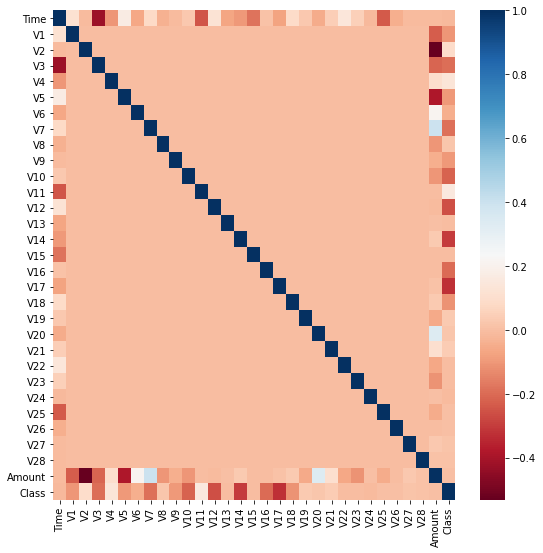

In [38]:
plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [43]:
def get_outlier(df=None, column=None, weight=1.5):
  # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함.
  fraud = df[df['Class']==1][column]
  quantile_25 = np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75)
  # IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함.
  iqr = quantile_75 - quantile_25
  iqr_weight = iqr * weight
  lowest_val = quantile_25 - iqr_weight
  highest_val = quantile_75 + iqr_weight
  # 최댓값보다 크거나 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index  반환

  outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
  return outlier_index

In [45]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')



총 4개의 데이터인 8296, 8615, 9035, 9252 번 Index가 이상치로 추출되었다.

get_outlier()를 이용해 이상치를 추출하고 이를 삭제하는 로직을 get_processed_df() 함수에 추가해 데이터를 가공한 뒤 이 데이터 세트를 이용해 로지스틱 회귀와 LightGBM 모델을 다시 적용한다.


In [49]:
# get_processed_df()를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경.

def get_preprocessed_df(df=None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  # 이상치 데이터 삭제하는 로직 추가
  outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
  df_copy.drop(outlier_index, axis=0, inplace=True)
  return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85291     4]
 [   25   121]]
정확도: 0.9997, 정밀도: 0.9680, 재현율: 0.8288, F1: 0.8930, AUC:0.9831



이상치 데이터를 제거한 뒤, 로지스틱 회귀와 LightGBM 모두 예측 성능이 크게 향상되었다.

로지스틱 회귀의 경우 재현율이 60.81%에서 67.12%로 크게 증가했으며, LightGBM의 경우도 76.35%에서 82.88%로 역시 크게 증가했다.

<br>

---



### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

이번에는 SMOTE 기법으로 오버 샘플링을 적용한 뒤 로지스틱 회귀와 LightGBM 모델의예측 성능을 평가한다.

먼저 SMOTE는 앞서 설치한 imbalanced-learn 패키지의 SMOTE 클래스를 이용해 간단하게 구현 가능하다.

SMOTE를 적용할 때는 반드시 학습 데이터 세트만 오버 샘플링 해야한다.

검증 데이터 세트나 테스트 데이터 세트를 오버샘플링할 경우 결국은 원본 데이터 세트가 아닌 데이터 세트에서 검증 또는 테스트를 수행하기 때문에 올바른 검증/테스트가 될 수 없다.



In [52]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용 전 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 1    199020
0    199020
dtype: int64


SMOTE 적용 전 학습 데이터는 199362 건이었지만

SMOTE 적용 후 2배에 가까운 398040 건으로 데이터가 증식 되었음.

그리고 SMOTE 적용 후 레이블 값이 0과 1의 분포가 동일하게 199020 건으로 생성되었다.

이제 이렇게 생성된 데이터 세트를 기반으로 먼저 로지스틱 회귀 모델을 학습한 뒤 성능을 평가한다.


In [53]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247, F1: 0.1023, AUC:0.9737


로지스틱 회귀 모델의 경우 SMOTE로 오버 샘플링된 데이터로 학습할 경우 재현율이 92.47%로 크게 증가하지만,

반대로 정밀도가 5.4%로 급격하게 저하된다.

재현율이 높더라도 이 정도로 저조한 정밀도로는 현실 업무에 적용할 수 없다.

이는 로지스틱 회귀 모델이 오버 샘플링으로 인해 실제 원본 데이터의 유형보다 너무나 많은 Class=1 데이터를 학습하면서 실제 테스트 데이터 세트에서 예측을 지나치게 Class=1로 적용해 정밀도가 급격히 떨어지게 된 것이다.

분류 결정 임곗값에 따른 정밀도와 재현율 곡선을 통해 SMOTE로 학습된 로지스틱 회귀 모델에 어떠한 문제가 발생하고 있는지 시각적으로 확인한다.



In [54]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
  # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
  precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)

  # X축을 threshold 값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행, 정밀도는 점선으로 표시
  plt.figure(figsize=(8, 6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='-', label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

  # threshold 값 X 축의 Scale을 0.1 단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))
  
  # x축, y축 label과 legend, 그리고 grid 설정
  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend(); plt.grid()
  plt

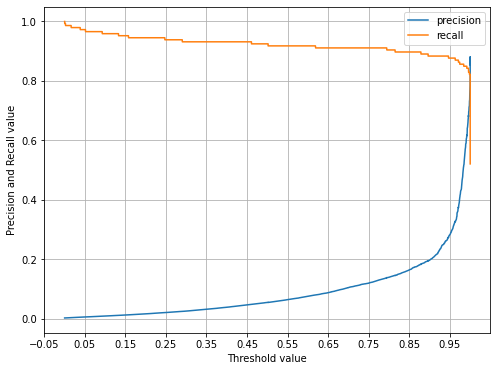

In [56]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])


임계값이 0.99 이하에서는 재현율이 매우 좋고 정밀도가 극단적으로 낮다가 0.99 이상에서는 반대로 재현율이 대폭 떨어지고 정밀도가 높아진다.

분류 결정 임계값을 조정하더라도 임계값의 민감도가 너무 심해 올바른 재현율/정밀도 성능을 얻을 수는 없으므로 로지스틱 회귀 모델의 경우 SMOTE 적용 후 올바른 예측 모델이 생성되지 못했다.

이번에는 LightGBM 모델을 SMOTE로 오버 샘플링된 데이터 세트로 학습/예측/평가를 수행한다.


In [60]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)

get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgㅡ_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85286     9]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9323, 재현율: 0.8493, F1: 0.8889, AUC:0.9789



재현율이 이상치만 제거한 경우인 82.88%보다 높은 84.93%가 되었다.

그러나 정밀도는 이전의 96.8%보다 낮은 93.23%이다.

SMOTE를 적용하면 재현율은 높아지나, 정밀도를 낮아지는 것이 일반적이다.

좋은 SMOTE 패키지일수록 재현율 증가율은 높이고 정밀도 감소율은 낮출 수 있도록 효과적으로 데이터를 증식한다.

